#  Modelo de clasificación de imagenes usando Transfer Learning (VGG16)

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.client import device_lib


IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3 # todavia no se que es esto
EPOCHS = 50 # ya se vera cual es el numero correcto // habia que hacer un rico for para ver que numero es


## Separamos las fotos en dos bloques, el bloque de entrenamiento (80%) y el bloque de validación (20%)

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Aves v3",
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "Aves v3",
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1584 files belonging to 9 classes.
Using 1268 files for training.
Found 1584 files belonging to 9 classes.
Using 316 files for validation.


## Mostramos las diferente classes que tienen las fotos que se van a utilizar para entrenar la inteligencia artificial

In [31]:
class_names = train_ds.class_names
indices = np.arange(len(class_names))
num_classes = len(class_names)
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'BEARDED BARBET',
 'CASPIAN TERN',
 'CEDAR WAXWING',
 'GREAT KISKADEE',
 'HOUSE FINCH']

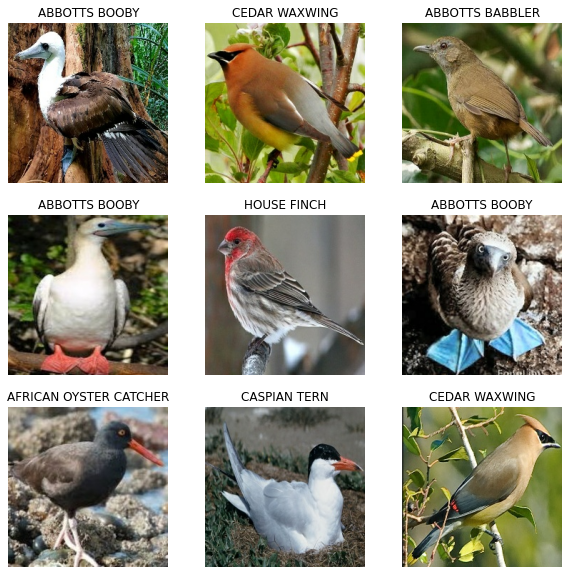

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
rescale_and_resize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [36]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Cogemos el modelo pre-entrenado VGG16 y lo entrenamos el modelo congelando todas las capas que tiene VGG16.
### Esto significa que las capas de VGG16 no se van a actualizar durante el entrenamiento
### Ademas añadimos mas capas como DROPOUT para ayudar a evitar el overfitting

In [37]:
vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
#eff_model.summary()
vgg_model.trainable = False

resize_layer = rescale_and_resize(vgg_model.output)
layer0 = tf.keras.layers.Flatten(name='flatten')(resize_layer)
layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
layer1_5 = tf.keras.layers.Dropout(0.5)(layer1)
layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
layer2_5 = tf.keras.layers.Dropout(0.5)(layer2)
out_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(layer2_5)
vgg_model = tf.keras.Model(vgg_model.input, out_layer)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
              #,
              #ModelCheckpoint(filepath='Fullmodel.{epoch:02d}-{acc:.2f}.h5', monitor='val_acc', save_best_only=False, mode='max')]
             ]

In [39]:
history = vgg_model.fit(
      train_ds, 
      epochs=15,
      verbose=1,
      validation_data = val_ds,
      callbacks=callbacks)

Epoch 1/15
40/40 [==============================] - 260s 6s/step - loss: 1.4504 - accuracy: 0.5726 - val_loss: 0.4660 - val_accuracy: 0.8703
Epoch 2/15
40/40 [==============================] - 253s 6s/step - loss: 0.3417 - accuracy: 0.9093 - val_loss: 0.2292 - val_accuracy: 0.9367
Epoch 3/15
40/40 [==============================] - 247s 6s/step - loss: 0.1600 - accuracy: 0.9566 - val_loss: 0.1586 - val_accuracy: 0.9304
Epoch 4/15
40/40 [==============================] - 246s 6s/step - loss: 0.0921 - accuracy: 0.9779 - val_loss: 0.1761 - val_accuracy: 0.9335
Epoch 5/15
40/40 [==============================] - 247s 6s/step - loss: 0.0618 - accuracy: 0.9866 - val_loss: 0.1267 - val_accuracy: 0.9525
Epoch 6/15
40/40 [==============================] - 244s 6s/step - loss: 0.0455 - accuracy: 0.9890 - val_loss: 0.1647 - val_accuracy: 0.9525
Epoch 7/15
40/40 [==============================] - 239s 6s/step - loss: 0.0382 - accuracy: 0.9905 - val_loss: 0.1096 - val_accuracy: 0.9620
Epoch 8/15
40

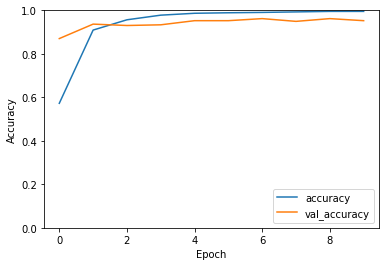

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

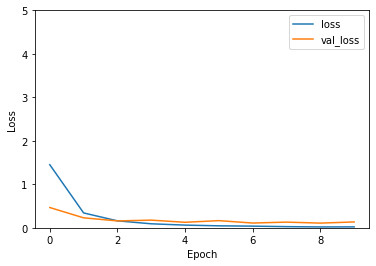

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')

## Una vez entrenado el modelo lo volvemos a entrenar pero esta vez descongelando las capas para que el modelo se enfoque en la resolución del problema de las aves

In [42]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.trainable = True
vgg_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
              #,
              #ModelCheckpoint(filepath='Fullmodel.{epoch:02d}-{acc:.2f}.h5', monitor='val_acc', save_best_only=False, mode='max')]
             ]

In [43]:
historyV_2 = vgg_model.fit(
      train_ds, 
      epochs=15,
      verbose=1,
      validation_data = val_ds,
      callbacks=callbacks)

Epoch 1/15
40/40 [==============================] - 855s 21s/step - loss: 1.3748 - accuracy: 0.7090 - val_loss: 0.4318 - val_accuracy: 0.8671
Epoch 2/15
40/40 [==============================] - 826s 21s/step - loss: 0.3700 - accuracy: 0.8872 - val_loss: 0.2095 - val_accuracy: 0.9304
Epoch 3/15
40/40 [==============================] - 833s 21s/step - loss: 0.1999 - accuracy: 0.9322 - val_loss: 0.4199 - val_accuracy: 0.8734
Epoch 4/15
40/40 [==============================] - 817s 20s/step - loss: 0.1630 - accuracy: 0.9448 - val_loss: 0.1554 - val_accuracy: 0.9335
Epoch 5/15
40/40 [==============================] - 800s 20s/step - loss: 0.1015 - accuracy: 0.9677 - val_loss: 0.1616 - val_accuracy: 0.9620
Epoch 6/15
40/40 [==============================] - 794s 20s/step - loss: 0.0799 - accuracy: 0.9779 - val_loss: 0.1328 - val_accuracy: 0.9399
Epoch 7/15
40/40 [==============================] - 800s 20s/step - loss: 0.0880 - accuracy: 0.9732 - val_loss: 0.1421 - val_accuracy: 0.9494
Epoch 

## Evaluamos el modelo

In [44]:
vgg_model.evaluate(val_ds,use_multiprocessing=True,workers=10)

10/10 [==============================] - 42s 4s/step - loss: 0.1461 - accuracy: 0.9652


[0.14614185690879822, 0.9651898741722107]

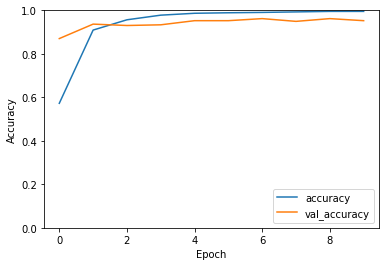

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

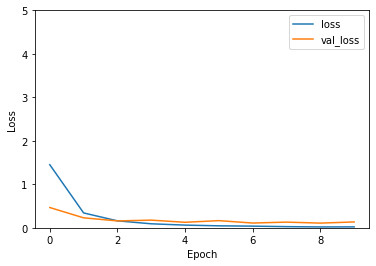

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')

## Guardamos el proyecto

In [48]:
vgg_model.save('saved_models/vgg16_weights_full_model_v2_standarization')

INFO:tensorflow:Assets written to: saved_models/vgg16_weights_full_model_v2_standarization\assets


In [9]:
ds = train_ds.map(lambda x, y: ((x, y), y))

In [18]:
model = tf.keras.models.load_model('C:/Users/aritz/OneDrive/Escritorio/MUUUH/3. maila/2/PBL/IA/saved_models/vgg16_weights_full_model_v2_standarization')

In [20]:
predicted_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  predicted_classes = np.concatenate([predicted_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

Test Accuracy:  0.9651898734177216


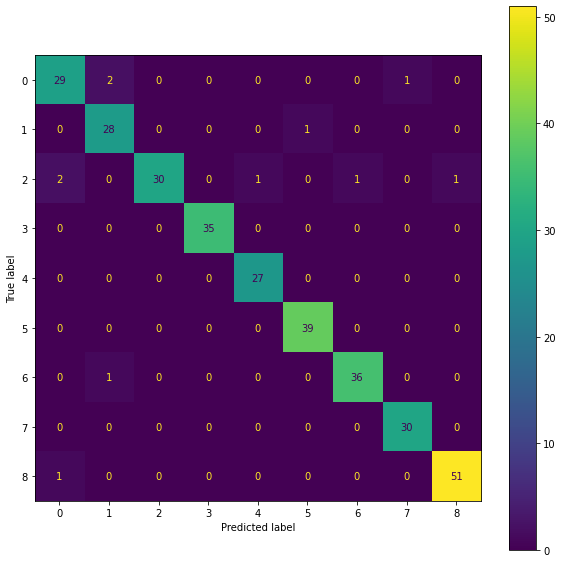

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
print("Test Accuracy: ", accuracy_score(true_classes, predicted_classes))